<a href="https://colab.research.google.com/github/Voidmort/Study-Notes-TensorFlow/blob/master/TensorFlow_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
title: TensorFlow 4
date: 2019-01-08 13:10:00
tags: Tensorflow
categories: Tensorflow
---

# 验证

通常我们会把数据分配为三分，训练集，交叉验证集和测试集，这样做的好处是为了避免过拟合，能够更好的泛化。

![训练集合](https://developers.google.com/machine-learning/crash-course/images/PartitionThreeSets.svg?hl=zh-cn)

添加验证集后，我们的工作流程大概是这样的：

![工作流程](https://developers.google.com/machine-learning/crash-course/images/WorkflowWithValidationSet.svg?hl=zh-cn)

接下来的练习是尝试使用这个流程来训练

与在之前的练习中一样，我们将使用加利福尼亚州住房数据集，尝试根据 1990 年的人口普查数据在城市街区级别预测 median_house_value。

# 设置

首先加载并准备数据。这一次使用多个特征，因此把逻辑模块化，以方便对特征进行预处理

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.cn/mledu-datasets/california_housing_train.csv", sep=",")

In [0]:
def preprocess_features(california_housing_dataframe):
    """从加州住房数据集获取输入数据
    参数:
        california_housing_dataframe:panda的 DataFrame 类型的数据集
    返回:
        用于模型feature的DataFrame        
    """
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]]
    
    processed_features = selected_features.copy()
    # Create a synthetic feature.
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"] /
        california_housing_dataframe["population"])
    return processed_features

def preprocess_targets(california_housing_dataframe):
    """准备目标特性(即来自加州住房数据集。
    参数:
        california_housing_dataframe:panda的 DataFrame 类型的数据集
    来自加州住房数据集。
    返回:
        用于模型feature的DataFrame 
    """
    output_targets = pd.DataFrame()
    # 将targets的单位扩到到千为单位
    output_targets["median_house_value"] = (
        california_housing_dataframe["median_house_value"] / 1000.0)
    return output_targets

我们从 17000 个样本中选前 12000 个样本 作 **训练集**

In [0]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,34.6,-118.5,27.5,2655.7,547.1,1476.0,505.4,3.8,1.9
std,1.6,1.2,12.1,2258.1,434.3,1174.3,391.7,1.9,1.3
min,32.5,-121.4,1.0,2.0,2.0,3.0,2.0,0.5,0.0
25%,33.8,-118.9,17.0,1451.8,299.0,815.0,283.0,2.5,1.4
50%,34.0,-118.2,28.0,2113.5,438.0,1207.0,411.0,3.5,1.9
75%,34.4,-117.8,36.0,3146.0,653.0,1777.0,606.0,4.6,2.3
max,41.8,-114.3,52.0,37937.0,5471.0,35682.0,5189.0,15.0,55.2


In [0]:
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.0
mean,198.0
std,111.9
min,15.0
25%,117.1
50%,170.5
75%,244.4
max,500.0


我们从 17000 个样本中选择后 5000 个为 **验证集**

In [0]:
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,38.1,-122.2,31.3,2614.8,521.1,1318.1,491.2,4.1,2.1
std,0.9,0.5,13.4,1979.6,388.5,1073.7,366.5,2.0,0.6
min,36.1,-124.3,1.0,8.0,1.0,8.0,1.0,0.5,0.1
25%,37.5,-122.4,20.0,1481.0,292.0,731.0,278.0,2.7,1.7
50%,37.8,-122.1,31.0,2164.0,424.0,1074.0,403.0,3.7,2.1
75%,38.4,-121.9,42.0,3161.2,635.0,1590.2,603.0,5.1,2.4
max,42.0,-121.4,52.0,32627.0,6445.0,28566.0,6082.0,15.0,18.3


In [0]:
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))
validation_targets.describe()

,median_house_value
count,5000.0
mean,229.5
std,122.5
min,15.0
25%,130.4
50%,213.0
75%,303.2
max,500.0


# 检查数据

 我们根据基准预期情况检查一下我们的数据：

* 对于一些值（例如 `median_house_value`），我们可以检查这些值是否位于合理的范围内（请注意，这是 1990 年的数据，不是现在的！）。

* 对于 `latitude` 和 `longitude` 等其他值，我们可以通过 Google 进行快速搜索，并快速检查一下它们与预期值是否一致。

如果您仔细看，可能会发现下列异常情况：

* `median_income` 位于 3 到 15 的范围内。我们完全不清楚此范围究竟指的是什么，看起来可能是某对数尺度？无法找到相关记录；我们所能假设的只是，值越高，相应的收入越高。

* `median_house_value` 的最大值是 500001。这看起来像是某种人为设定的上限。

* `rooms_per_person` 特征通常在正常范围内，其中第 75 百分位数的值约为 2。但也有一些非常大的值（例如 18 或 55），这可能表明数据有一定程度的损坏。

# 绘制维度/经度与房屋价值中位数的曲线图

 我们来详细了解一下 **`latitude`** 和 **`longitude`** 这两个特征。它们是相关城市街区的地理坐标。

利用这两个特征可以提供出色的可视化结果 - 我们来绘制 `latitude` 和 `longitude` 的曲线图，然后用颜色标注 `median_house_value`。

In [0]:
def plot_scatter(training_examples, training_targets, validation_examples, validation_targets):
    plt.figure(figsize=(13, 8))

    ax = plt.subplot(1, 2, 1)
    ax.set_title("Validation Data")

    ax.set_autoscaley_on(False)
    ax.set_ylim([32, 43])
    ax.set_autoscalex_on(False)
    ax.set_xlim([-126, -112])
    plt.scatter(validation_examples["longitude"],
                validation_examples["latitude"],
                cmap="coolwarm",
                c=validation_targets["median_house_value"] / validation_targets["median_house_value"].max())

    ax = plt.subplot(1, 2, 2)
    ax.set_title("Training Date")

    ax.set_autoscaley_on(False)
    ax.set_ylim([32, 43])
    ax.set_autoscalex_on(False)
    ax.set_xlim([-126, -112])
    plt.scatter(training_examples["longitude"],
                training_examples["latitude"],
                cmap="coolwarm",
                c=training_targets["median_house_value"] / training_targets["median_house_value"].max())
    _ = plt.plot()

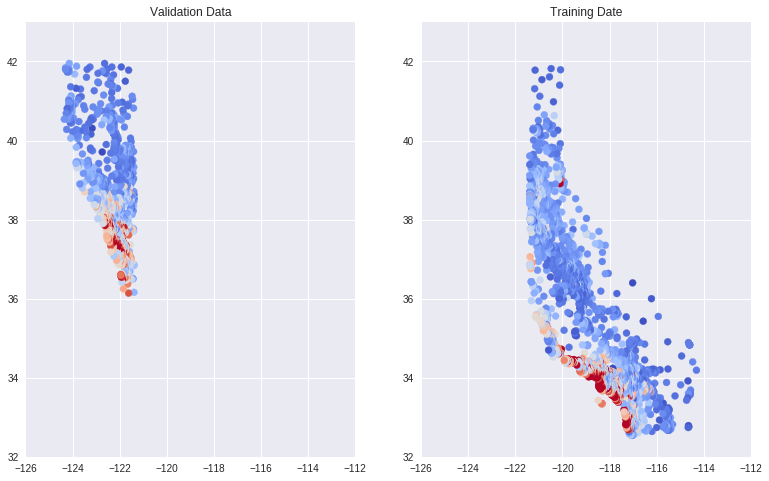

In [0]:
plot_scatter(training_examples, training_targets, validation_examples, validation_targets)

现在应该已经呈现出一幅不错的加利福尼亚州地图了，其中旧金山和洛杉矶等住房成本高昂的地区用红色表示。

根据训练集呈现的地图有几分像[真正的地图](https://www.google.com/maps/place/California/@37.1870174,-123.7642688,6z/data=!3m1!4b1!4m2!3m1!1s0x808fb9fe5f285e3d:0x8b5109a227086f55)，但根据验证集呈现的明显不像。

 查看上面的摘要统计信息表格时，很容易产生想知道如何进行有用的数据检查的想法。每个街区 total_rooms 的第 <sup>75</sup> 百分位的正确值是什么？

需要注意的关键一点是，对于任何指定特征或列，训练集和验证集之间的值的分布应该大致相同。

我们真正需要担心的是，真实情况并非这样，这一事实表明我们创建训练集和验证集的拆分方式很可能存在问题。

# 随机化处理数据

我们需要在读入数据时，对数据进行随机化处理的。

如果我们在创建训练集和验证集之前，没有对数据进行正确的随机化处理，那么以某种特定顺序接收数据可能会导致出现问题（似乎就是此时的问题）。

 发现并解决问题后，重新运行上面的 `latitude`/`longitude` 绘图单元格，并确认我们的健全性检查的结果看上去更好了。

顺便提一下，在这一步中，我们会学到一项重要经验。

**机器学习中的调试通常是*数据调试*而不是代码调试。**

如果数据有误，即使最高级的机器学习代码也挽救不了局面。

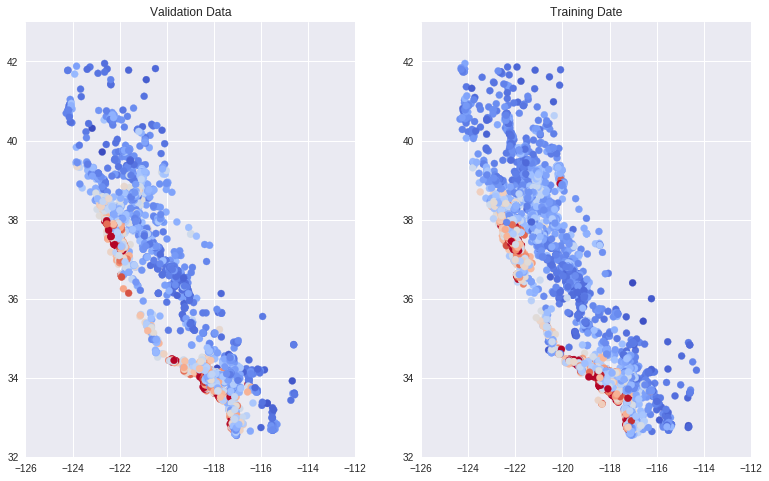

In [0]:
california_housing_dataframe = california_housing_dataframe.reindex(
     np.random.permutation(california_housing_dataframe.index))

training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

plot_scatter(training_examples, training_targets, validation_examples, validation_targets)

好的，这次的结果来看训练集和验证集都有相似的分布。

# 训练和评估模型

尝试不同的超参数，获得最佳验证效果。

首先定义输入函数

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key: np.array(value) for key, value in dict(features).items()}
    
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

由于我们现在使用的是多个输入特征，因此需要把用于将特征列配置为独立函数的代码模块化。（目前此代码相当简单，因为我们的所有特征都是数值，但当我们在今后的练习中使用其他类型的特征时，会基于此代码进行构建。）

In [0]:
def construct_feature_columns(input_features):
    """构造TensorFlow特征列
        参数:
            input_features:要使用的数字输入特性的名称。
        返回:
            一个 feature columns 集合
    """
    return set([tf.feature_column.numeric_column(my_feature) 
                for my_feature in input_features])

 接下来，继续完成 `train_model()` 代码，以设置输入函数和计算预测。

**注意**：可以参考以前的练习中的代码，但要确保针对相应数据集调用 `predict()`。

比较训练数据和验证数据的损失。使用一个原始特征时，我们得到的最佳均方根误差 (RMSE) 约为 180。

现在我们可以使用多个特征，不妨看一下可以获得多好的结果。

使用我们之前了解的一些方法检查数据。这些方法可能包括：

   * 比较预测值和实际目标值的分布情况

   * 绘制预测值和目标值的散点图

   * 使用 `latitude` 和 `longitude` 绘制两个验证数据散点图：
      * 一个散点图将颜色映射到实际目标 `median_house_value`
      * 另一个散点图将颜色映射到预测的 `median_house_value`，并排进行比较。

In [0]:
def train_model(
    learning_rate,
    strps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    """训练多元特征的线性回归模型
        除训练外，此功能还打印训练进度信息，
        以及随着时间的推移而失去的训练和验证。
    参数:
        learning_rate:一个float，表示学习率
        steps:一个非零的int，训练步骤的总数。训练步骤
            由使用单个批处理的向前和向后传递组成。
        batch_size:一个非零的int
        training_example: DataFrame 包含一个或多个列
        '  california_housing_dataframe '作为训练的输入feature
        training_targets:一个' DataFrame '，它只包含一列
        ' california_housing_dataframe '作为训练的目标。
        validation_example: ' DataFrame '包含一个或多个列
        ' california_housing_dataframe '作为验证的输入feature
        validation_targets: ' DataFrame '，仅包含来自其中的一列
        ' california_housing_dataframe '作为验证的目标。
    返回:
        在训练数据上训练的“线性回归器”对象
    """
    periods = 10
    steps_per_period = strps / periods
    
    # 创建一个线性回归对象
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=construct_feature_columns(training_examples),
        optimizer=my_optimizer
    )
    
    # 创建输入函数
    training_input_fn = lambda: my_input_fn(
        training_examples,
        training_targets["median_house_value"],
        batch_size=batch_size)
    
    predict_training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)
    
    predict_validation_input_fn = lambda: my_input_fn(
        validation_examples, 
        validation_targets["median_house_value"],
        num_epochs=1,
        shuffle=False)
    
    #训练模型，但要在循环中进行，这样我们才能定期评估
    #损失指标
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
      # Train the model, starting from the prior state.
      linear_regressor.train(
          input_fn=training_input_fn,
          steps=steps_per_period,
      )
      # Take a break and compute predictions.
      training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
      training_predictions = np.array([item['predictions'][0] for item in training_predictions])
      
      validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
      validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
      
      
      # Compute training and validation loss.
      training_root_mean_squared_error = math.sqrt(
          metrics.mean_squared_error(training_predictions, training_targets))
      validation_root_mean_squared_error = math.sqrt(
          metrics.mean_squared_error(validation_predictions, validation_targets))
      # Occasionally print the current loss.
      print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
      # Add the loss metrics from this period to our list.
      training_rmse.append(training_root_mean_squared_error)
      validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    return linear_regressor    

Training model...
RMSE (on training data):
  period 00 : 217.57
  period 01 : 200.14
  period 02 : 185.74
  period 03 : 175.52
  period 04 : 170.71
  period 05 : 167.06
  period 06 : 165.72
  period 07 : 165.65
  period 08 : 166.77
  period 09 : 168.40
Model training finished.


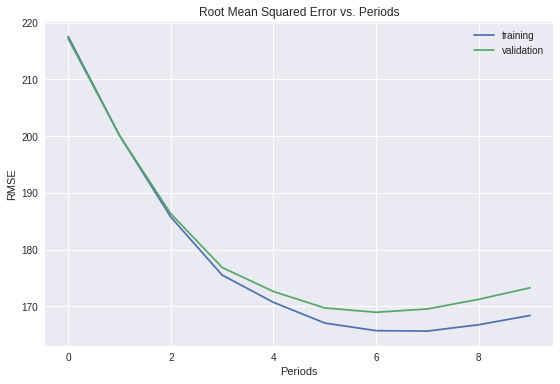

In [0]:
linear_regressor = train_model(
    learning_rate=0.00003,
    strps=500,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

# 基于测试数据进行评估

**载入测试数据集并据此评估模型。**

我们已对验证数据进行了大量迭代。接下来确保我们没有过拟合该特定样本集的特性。

测试数据集位于[此处](https://download.mlcc.google.cn/mledu-datasets/california_housing_test.csv)。

In [0]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.cn/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_test_input_fn = lambda: my_input_fn(
      test_examples, 
      test_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)

test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Final RMSE (on test data): 162.99
